In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [6]:
# Connect to the database
conn = sqlite3.connect('obesity_data.db')
# Load data from SQLite database
query = "SELECT * FROM obesity_data;"
df = pd.read_sql(query, conn)

# View the first few rows
df.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,BMI,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,Normal_Weight,24.386526,...,0,0,0,0,0,1,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,Normal_Weight,24.238227,...,0,1,1,0,1,0,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,Normal_Weight,23.765432,...,0,0,0,1,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,Overweight_Level_I,26.851852,...,0,0,0,1,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,Overweight_Level_II,28.342381,...,0,0,0,0,1,0,0,0,1,0


In [7]:
# Check data types and missing values
print(df.info())

# Summary statistics
print(df.describe())

# Check class distribution for 'Obesity_Class'
print(df['Obesity_Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   NObeyesdad                          2111 non-null   object 
 9   BMI                                 2111 non-null   float64
 10  Obesity_Class                       2111 non-null   object 
 11  Gender_Male                         2111 no

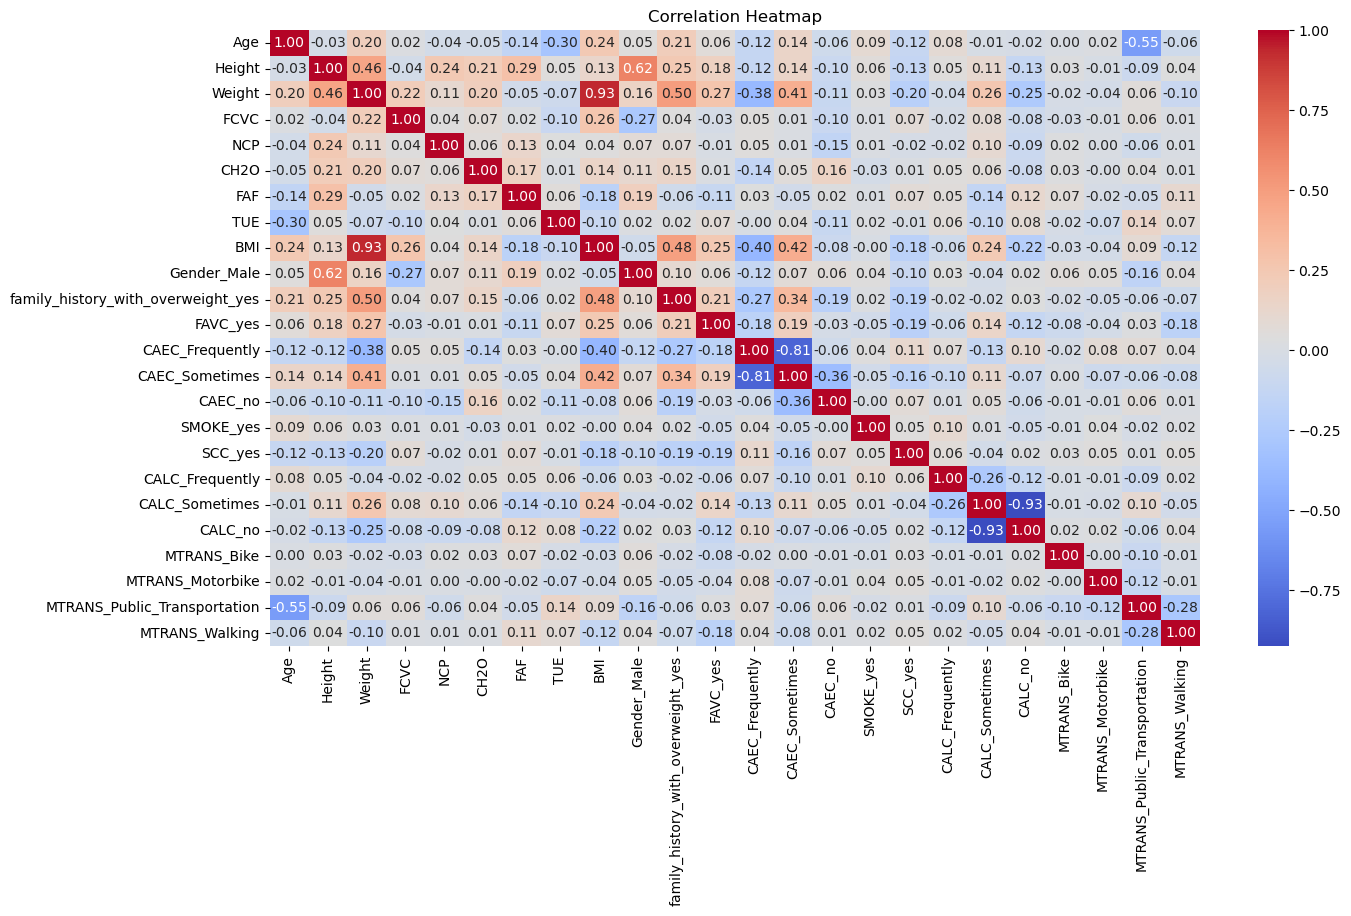

In [8]:
# Exclude categorical columns for correlation
corr = df.select_dtypes(include=['float', 'int']).corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [9]:
# Define features and target
X = df.drop(columns=['Obesity_Class', 'NObeyesdad'])
y = df['Obesity_Class']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Identify numerical and categorical columns
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
categorical_features = [col for col in X.columns if col not in numeric_features]

# Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Combine preprocessing with model in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [11]:
# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9905437352245863

Classification Report:
                      precision    recall  f1-score   support

      Normal Weight       0.97      0.99      0.98        67
 Overweight_Level_I       0.99      0.99      0.99       101
Overweight_Level_II       1.00      1.00      1.00       201
        Underweight       0.98      0.98      0.98        54

           accuracy                           0.99       423
          macro avg       0.99      0.99      0.99       423
       weighted avg       0.99      0.99      0.99       423



In [12]:
# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9905437352245863

Classification Report:
                      precision    recall  f1-score   support

      Normal Weight       0.97      0.99      0.98        67
 Overweight_Level_I       0.99      0.99      0.99       101
Overweight_Level_II       1.00      1.00      1.00       201
        Underweight       0.98      0.98      0.98        54

           accuracy                           0.99       423
          macro avg       0.99      0.99      0.99       423
       weighted avg       0.99      0.99      0.99       423



In [13]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy: 0.9730373208743683


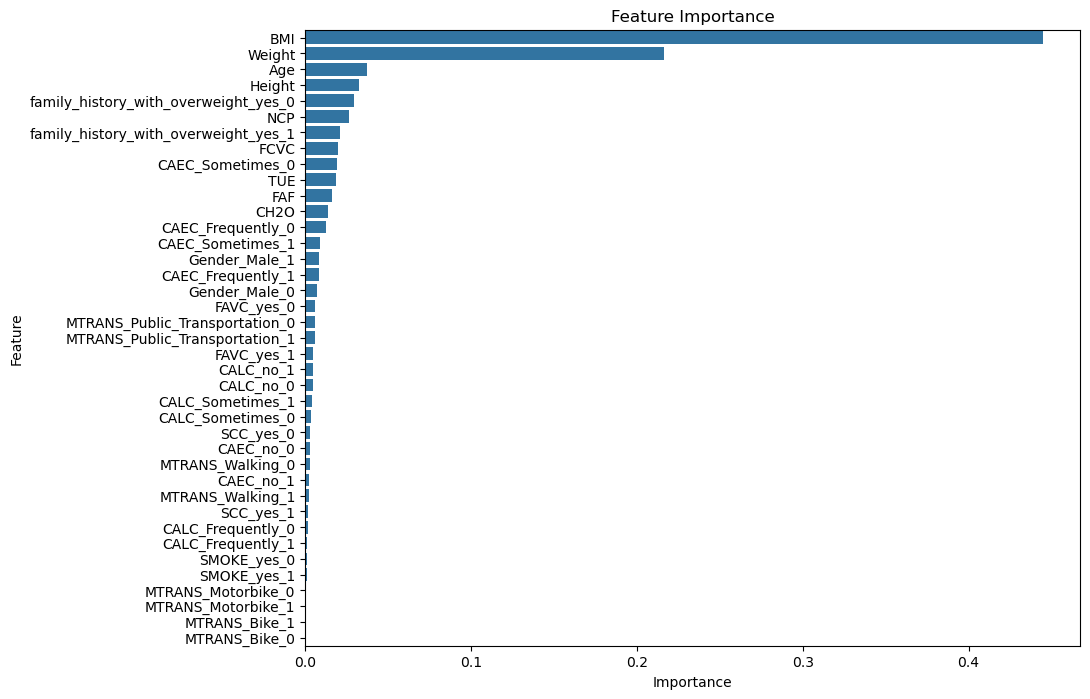

In [14]:
# Access feature importance from the trained Random Forest
feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
importances = pipeline.named_steps['classifier'].feature_importances_

# Create a feature importance plot
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importance")
plt.show()

In [15]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best Cross-Validation Score: 0.9887444190902407


In [16]:
joblib.dump(pipeline, 'obesity_classifier_model.pkl')
print("Model saved as 'obesity_classifier_model.pkl'")

Model saved as 'obesity_classifier_model.pkl'


In [17]:
# Load the saved model
model = joblib.load('obesity_classifier_model.pkl')

# Sample input data (you can test different inputs here)
sample_data = {
    "Age": 35,
    "Height": 1.60,
    "Weight": 150,
    "FCVC": 3,
    "NCP": 3,
    "CH2O": 2,
    "FAF": 2,
    "TUE": 1,
    "BMI": 80.9,
    "Gender_Male": 1,
    "family_history_with_overweight_yes": 1,
    "FAVC_yes": 0,
    "CAEC_Frequently": 0,
    "CAEC_Sometimes": 0,
    "CAEC_no": 0,
    "SMOKE_yes": 0,
    "SCC_yes": 0,
    "CALC_Frequently": 0,
    "CALC_Sometimes": 1,
    "CALC_no": 0,
    "MTRANS_Bike": 0,
    "MTRANS_Motorbike": 0,
    "MTRANS_Public_Transportation": 1,
    "MTRANS_Walking": 0
}

# Convert to DataFrame
input_df = pd.DataFrame([sample_data])

# Make prediction
prediction = model.predict(input_df)
print(f"Model Prediction: {prediction}")


Model Prediction: ['Overweight_Level_II']
